In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
# from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFE, MutualInfoClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import VarianceThreshold

In [2]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Plot styling
plt.style.use('ggplot')
sns.set_palette("husl")

# Define Column Names for NSL-KDD (Standard List)
COL_NAMES = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label", "difficulty_level"]

In [3]:
train_path = './data/KDDTrain+.txt'
test_path = './data/KDDTest+.txt'

# Try loading with error handling for paths
try:
    df_train = pd.read_csv(train_path, header=None, names=COL_NAMES)
    df_test = pd.read_csv(test_path, header=None, names=COL_NAMES)
    print(f"Training Data Shape: {df_train.head()}")
    print(f"Test Data Shape: {df_test.tail()}")
except FileNotFoundError:
    print("Files not found. Please check the paths. Trying absolute paths or checking local directory...")
    if os.path.exists('KDDTrain+.txt'):
        df_train = pd.read_csv('KDDTrain+.txt', header=None, names=COL_NAMES)
        df_test = pd.read_csv('KDDTest+.txt', header=None, names=COL_NAMES)

df_train.head()

Training Data Shape:    duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1                    0.60                         0

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [4]:
# Mapping Dictionary
attack_mapping = {
    'normal': 'normal',
    
    # DoS
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS', 'mailbomb': 'DoS', 'apache2': 'DoS', 'processtable': 'DoS', 'udpstorm': 'DoS',
    
    # Probe
    'satan': 'Probe', 'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'mscan': 'Probe', 'saint': 'Probe',
    
    # R2L
    'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L', 'phf': 'R2L', 'multihop': 'R2L', 'warezmaster': 'R2L', 'warezclient': 'R2L', 'spy': 'R2L', 'xlock': 'R2L', 'xsnoop': 'R2L', 'snmpguess': 'R2L', 'snmpgetattack': 'R2L', 'httptunnel': 'R2L', 'sendmail': 'R2L', 'named': 'R2L',
    
    # U2R
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R', 'ps': 'U2R', 'xterm': 'U2R', 'sqlattack': 'U2R'
}

# Apply mapping
df_train['attack_class'] = df_train['label'].map(lambda x: attack_mapping.get(x, 'other'))
df_test['attack_class'] = df_test['label'].map(lambda x: attack_mapping.get(x, 'other'))

print("Training Class Distribution:")
print(df_train['attack_class'].value_counts())

Training Class Distribution:
attack_class
normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64


In [5]:
#Defining feature Groups

categorical_features = ['protocol_type','service','flag']
binary_features = ['land','logged_in','is_host_login','is_guest_login']
#All the other numerical values

numerical_features = [col for col in COL_NAMES if col not in categorical_features + binary_features +['label','difficulty_level']]

print(f"Categorical Features: {len(categorical_features)}")
print(f"Binary Features: {len(binary_features)}")
print(f"Numerical Features: {len(numerical_features)}")

Categorical Features: 3
Binary Features: 4
Numerical Features: 34


In [6]:
missing = df_train.isnull().sum()
print("Missing values:")
print(missing[missing > 0] if missing.sum() > 0 else "No missing values found.")

Missing values:
No missing values found.


In [7]:
def clean_outliers_isolation_forest(df,contamination = 0.01):
    iso_df  = df[numerical_features].copy()

    clf = IsolationForest(max_samples='auto',contamination = contamination, random_state = 42)

    outliers = clf.fit_predict(iso_df)

    n_outliers = (outliers == -1).sum()
    print(f"Identifies {n_outliers} Outlilers using the Isolation forest")

    return outliers
df_train['is_outlier'] = clean_outliers_isolation_forest(df_train)

Identifies 1256 Outlilers using the Isolation forest


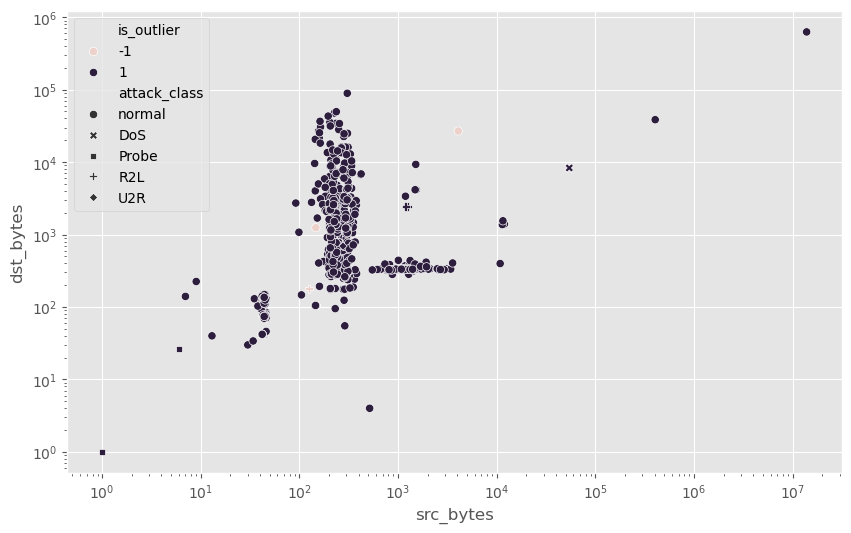

In [8]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_train[::100], x = 'src_bytes', y = 'dst_bytes', hue='is_outlier', style='attack_class')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [9]:
skewed_cols = ['duration', 'src_bytes', 'dst_bytes']

skewness_before = df_train[skewed_cols].skew()

log_cols = {}
for col in skewed_cols:
    log_cols[f'log_{col}'] = np.log1p(df_train[col])

log_df          = pd.DataFrame(log_cols, index=df_train.index)
skewness_after  = log_df.skew()

skewness_summary = pd.DataFrame({
    'feature'         : skewed_cols,
    'skewness_original': skewness_before.values,
    'skewness_log1p'  : skewness_after.values
})

print("Skewness Summary:")
print(skewness_summary.to_string(index=False))

Skewness Summary:
  feature  skewness_original  skewness_log1p
 duration          11.880230        5.338451
src_bytes         190.669347        0.310643
dst_bytes         290.052911        0.493738



Correlation Matrix (original + log-transformed):
               duration  src_bytes  dst_bytes  log_duration  log_src_bytes  \
duration         1.0000     0.0707     0.0349        0.7214        -0.0255   
src_bytes        0.0707     1.0000     0.0002        0.0408         0.0418   
dst_bytes        0.0349     0.0002     1.0000        0.0282        -0.0041   
log_duration     0.7214     0.0408     0.0282        1.0000         0.1039   
log_src_bytes   -0.0255     0.0418    -0.0041        0.1039         1.0000   
log_dst_bytes   -0.0292    -0.0051     0.0224        0.0835         0.7024   

               log_dst_bytes  
duration             -0.0292  
src_bytes            -0.0051  
dst_bytes             0.0224  
log_duration          0.0835  
log_src_bytes         0.7024  
log_dst_bytes         1.0000  


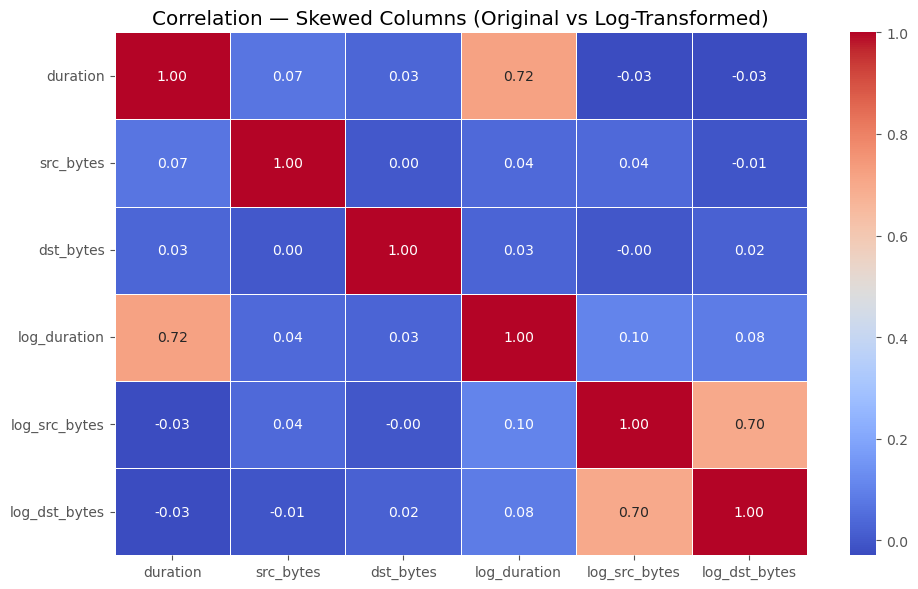

In [10]:
#Correlation between skewed columns (original & log-transformed) ──
combined_for_corr = pd.concat([df_train[skewed_cols], log_df], axis=1)
corr_matrix       = combined_for_corr.corr()

print("\nCorrelation Matrix (original + log-transformed):")
print(corr_matrix.round(4))

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation — Skewed Columns (Original vs Log-Transformed)')
plt.tight_layout()
plt.show()

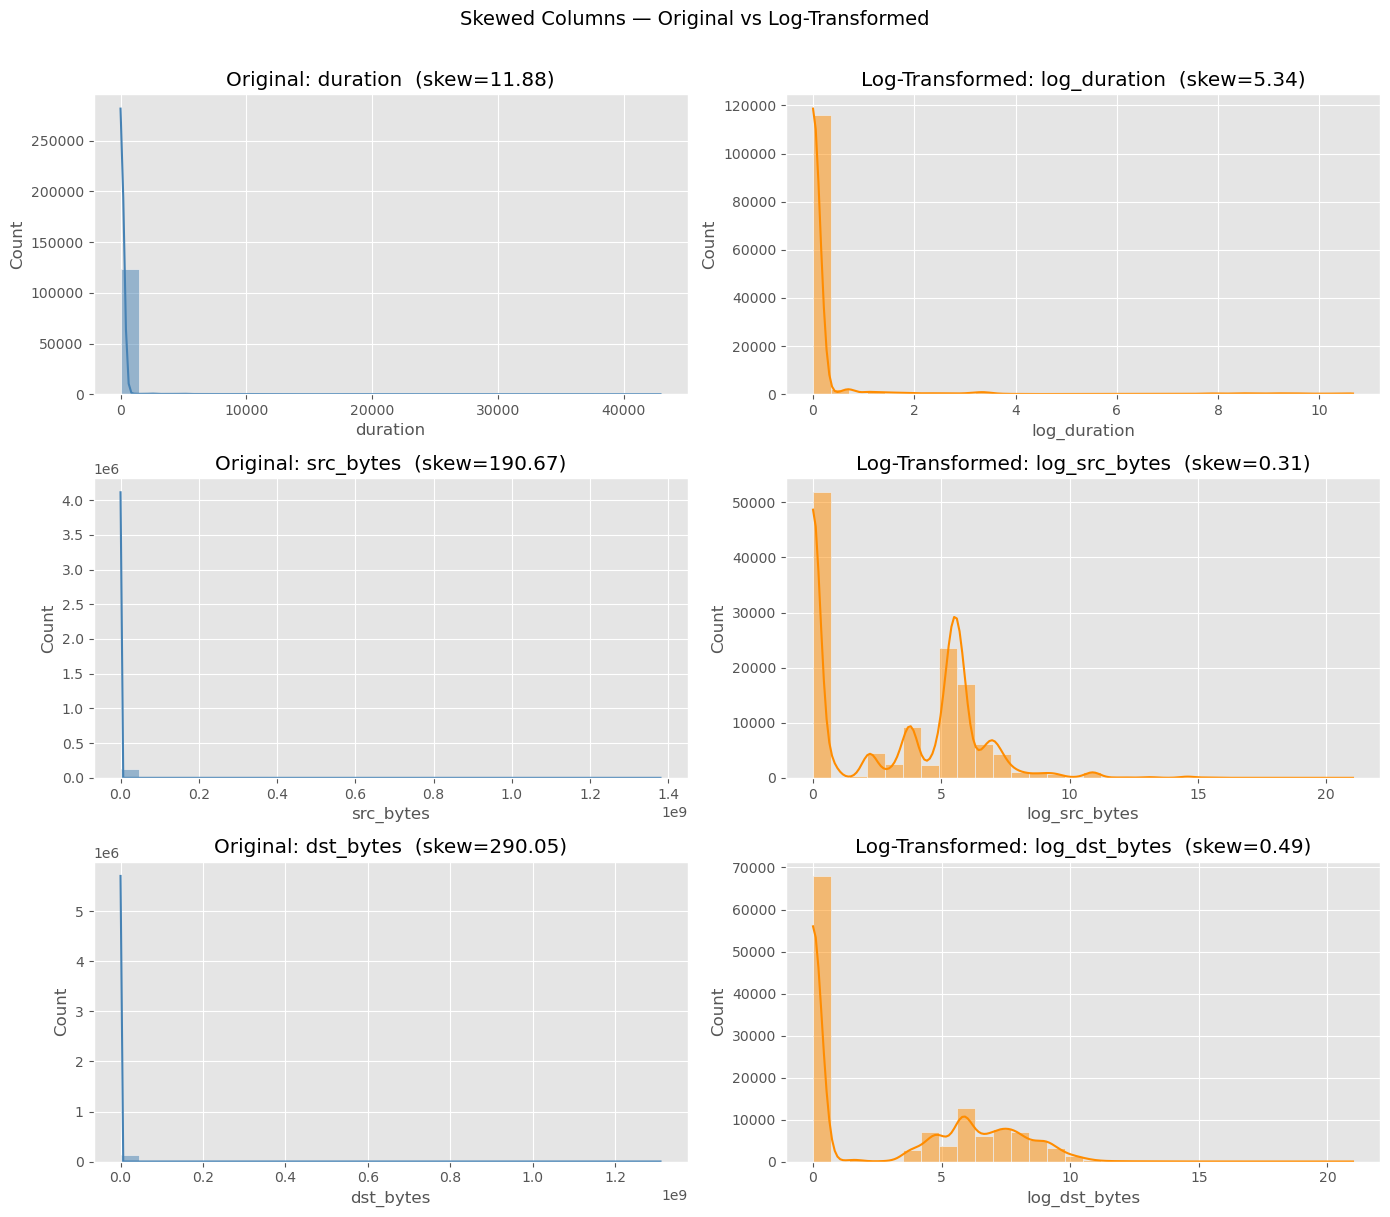

In [11]:
#Before vs After distribution plots
fig, axes = plt.subplots(len(skewed_cols), 2, figsize=(14, 4 * len(skewed_cols)))

for i, col in enumerate(skewed_cols):
    sns.histplot(df_train[col], bins=30, kde=True, ax=axes[i][0], color='steelblue')
    axes[i][0].set_title(f'Original: {col}  (skew={skewness_before[col]:.2f})')

    sns.histplot(log_df[f'log_{col}'], bins=30, kde=True, ax=axes[i][1], color='darkorange')
    axes[i][1].set_title(f'Log-Transformed: log_{col}  (skew={skewness_after[f"log_{col}"]:.2f})')

plt.suptitle('Skewed Columns — Original vs Log-Transformed', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

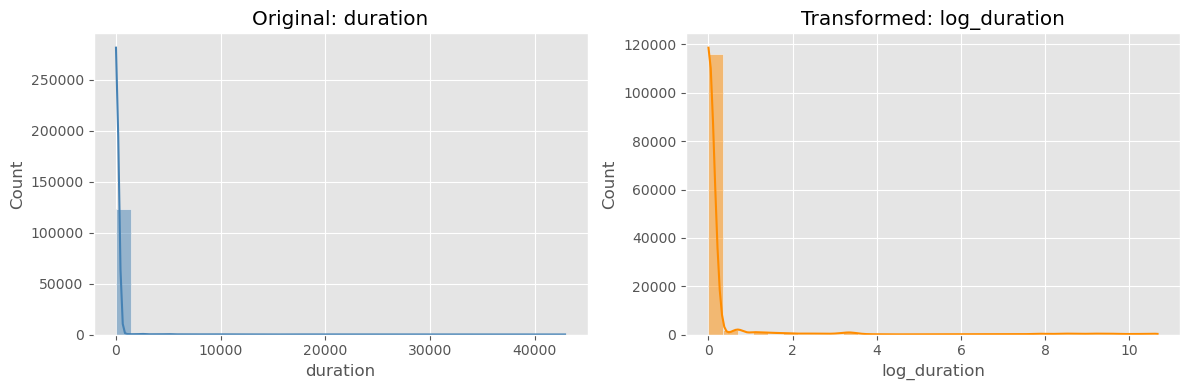

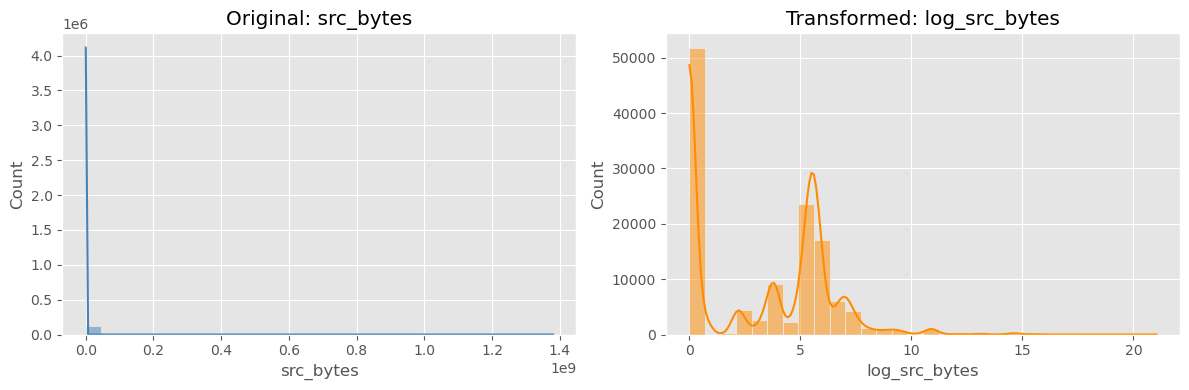

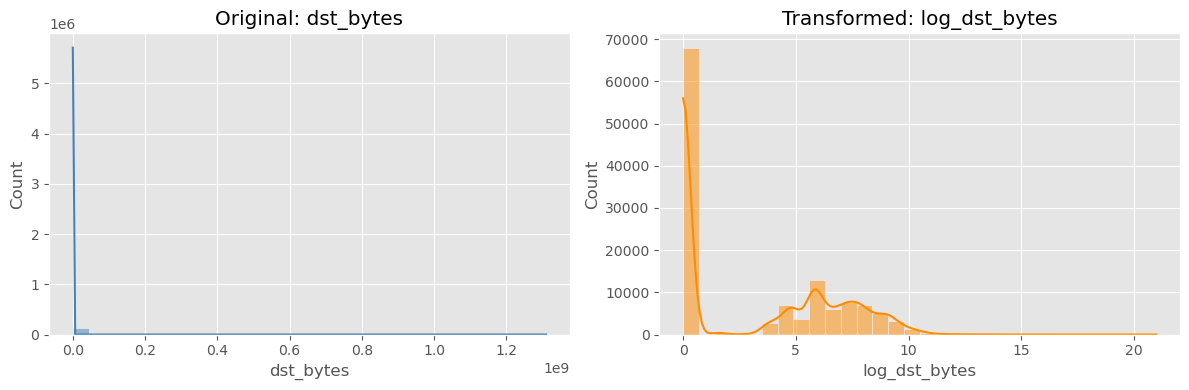

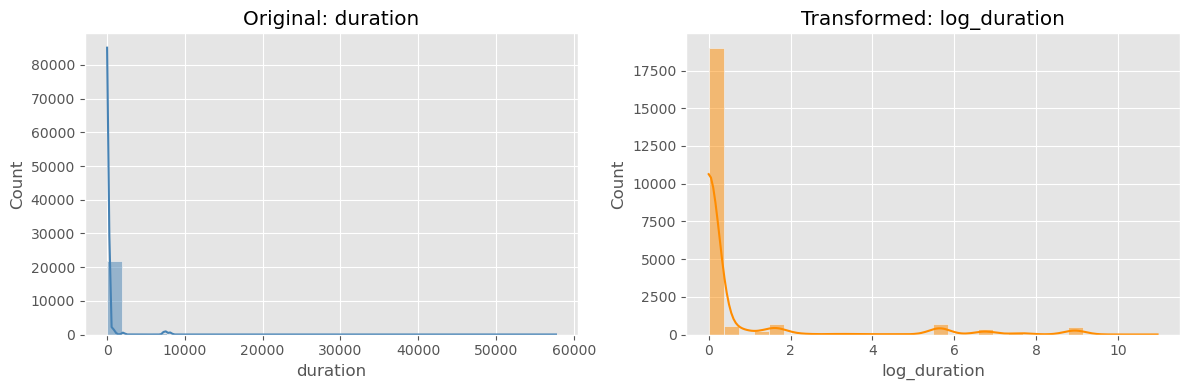

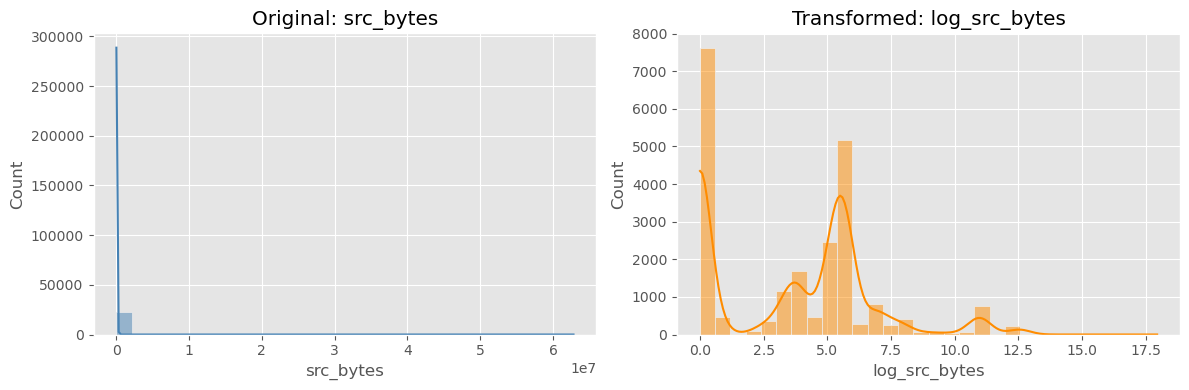

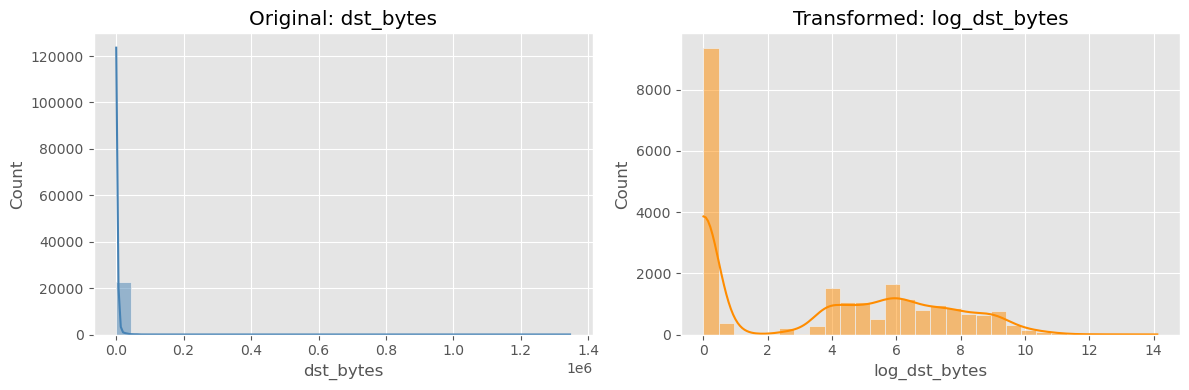

In [12]:
def apply_log_transform(df, cols):
    df_transform = df.copy()                  
    for col in cols:
        new_col = f'log_{col}'
        df_transform[new_col] = np.log1p(df_transform[col])

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        sns.histplot(df[col], bins=30, kde=True, ax=axes[0], color='steelblue')
        axes[0].set_title(f'Original: {col}')

        sns.histplot(df_transform[new_col], bins=30, kde=True, ax=axes[1], color='darkorange')
        axes[1].set_title(f'Transformed: log_{col}')

        plt.tight_layout()
        plt.show()

    return df_transform

df_train = apply_log_transform(df_train, skewed_cols)
df_test  = apply_log_transform(df_test,  skewed_cols)

In [13]:
def engineer_features(df):
    df_eng = df.copy()
    
    # 1. Total Bytes
    df_eng['total_bytes'] = df_eng['src_bytes'] + df_eng['dst_bytes']
    
    # 2. Byte Ratio (Handle division by zero)
    df_eng['src_bytes_ratio'] = df_eng['src_bytes'] / (df_eng['total_bytes'] + 1e-5)
    
    # 3. Load / Packet Rate
    # If duration is 0, we assume it's a single instantaneous event (rate = count)
    df_eng['packet_rate'] = df_eng['count'] / (df_eng['duration'] + 1e-5)
    
    # 4. Title: Flow Asymmetry
    df_eng['byte_diff'] = abs(df_eng['src_bytes'] - df_eng['dst_bytes'])
    
    # 5. Flag interactions (example: is it an error flag?)
    error_flags = ['S0', 'S1', 'S2', 'S3', 'REJ']
    df_eng['is_error_flag'] = df_eng['flag'].isin(error_flags).astype(int)
    
    # 6. Critical Host Interaction
    # Interaction between 'same_srv_rate' and 'dst_host_same_srv_rate'
    df_eng['same_srv_interaction'] = df_eng['same_srv_rate'] * df_eng['dst_host_same_srv_rate']
    
    return df_eng

df_train = engineer_features(df_train)
df_test = engineer_features(df_test)

print("New Feature Set Head:")
print(df_train[['src_bytes_ratio', 'packet_rate', 'is_error_flag', 'same_srv_interaction']].head())

New Feature Set Head:
   src_bytes_ratio  packet_rate  is_error_flag  same_srv_interaction
0         1.000000     200000.0              0                 0.170
1         1.000000    1300000.0              0                 0.000
2         0.000000   12300000.0              1                 0.005
3         0.027668     500000.0              0                 1.000
4         0.321486    3000000.0              0                 1.000


In [14]:

ohe = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
cols_to_encode = ['protocol_type','flag']

#Fit and Train

ohe_train = pd.DataFrame(ohe.fit_transform(df_train[cols_to_encode]))
ohe_train.columns = ohe.get_feature_names_out(cols_to_encode)
ohe_train.index = df_train.index
# ohe_train.index

#Transform Test

ohe_test = pd.DataFrame(ohe.transform(df_test[cols_to_encode]))
ohe_test.columns = ohe.get_feature_names_out(cols_to_encode)
ohe_test.index = df_test.index

service_freq = df_train['service'].value_counts(normalize = True)
df_train['service_freq'] = df_train['service'].map(service_freq)
df_test['service_freq'] = df_test['service'].map(service_freq).fillna(0)

df_train_encode = pd.concat([df_train,ohe_train],axis = 1)
df_test_encode = pd.concat([df_test,ohe_test],axis = 1)

df_train_encode.columns
# df_train_encode

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label', 'difficulty_level', 'attack_class',
       'is_outlier', 'log_duration', 'log_src_bytes', 'log_dst_bytes',
       'total_bytes', 'src_bytes_ratio', 'packet_rate', 'byte_dif

In [15]:
print(df_train_encode.columns)

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label', 'difficulty_level', 'attack_class',
       'is_outlier', 'log_duration', 'log_src_bytes', 'log_dst_bytes',
       'total_bytes', 'src_bytes_ratio', 'packet_rate', 'byte_dif

In [16]:
df_test_encode

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,tcp,private,REJ,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,tcp,smtp,SF,794,333,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22540,0,tcp,http,SF,317,938,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22541,0,tcp,http,SF,54540,8314,0,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22542,0,udp,domain_u,SF,42,42,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
df_train_encode.drop(columns=['protocol_type','flag','service'],inplace = True)
df_test_encode.drop(columns=['protocol_type','flag','service'],inplace = True)

In [18]:
print(df_train_encode.shape)
df_test_encode

(125973, 66)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,12983,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,20,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,0,15,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,794,333,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22540,0,317,938,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22541,0,54540,8314,0,0,0,2,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22542,0,42,42,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
print(f"Train shape after encoding: {df_train_encode.shape}")
print(f"Test  shape after encoding: {df_test_encode.shape}")

Train shape after encoding: (125973, 66)
Test  shape after encoding: (22544, 65)


In [20]:
# Encode target label for feature selection
le = LabelEncoder()
y_train = le.fit_transform(df_train_encode['attack_class'])

# Drop non-feature columns
drop_meta = ['label', 'difficulty_level', 'attack_class', 'is_outlier']
drop_meta = [c for c in drop_meta if c in df_train_encode.columns]

X_train_fs = df_train_encode.drop(columns=drop_meta).copy()
X_test_fs  = df_test_encode.drop(
    columns=[c for c in drop_meta if c in df_test_encode.columns]
).copy()

# Align test columns to train
X_test_fs = X_test_fs.reindex(columns=X_train_fs.columns, fill_value=0)

print(f"Feature matrix shape before selection: {X_train_fs.shape}")
print(f"Total features: {X_train_fs.shape[1]}")

Feature matrix shape before selection: (125973, 62)
Total features: 62


In [21]:
# Features correlated above 0.95 are redundant — keep only one from each pair
corr_matrix_fs = X_train_fs.corr().abs()

# Take upper triangle to avoid duplicate pairs
upper_tri = corr_matrix_fs.where(
    np.triu(np.ones(corr_matrix_fs.shape), k=1).astype(bool)
)

# Find columns with any correlation > 0.95
high_corr_cols = [col for col in upper_tri.columns if any(upper_tri[col] > 0.95)]

X_train_fs.drop(columns=high_corr_cols, inplace=True)
X_test_fs.drop(columns=high_corr_cols,  inplace=True)

print(f"Features removed (high correlation > 0.95) : {len(high_corr_cols)}")
print(f"Removed features: {high_corr_cols}")
print(f"Features remaining: {X_train_fs.shape[1]}")

Features removed (high correlation > 0.95) : 10
Removed features: ['num_root', 'srv_serror_rate', 'srv_rerror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_srv_rerror_rate', 'packet_rate', 'byte_diff', 'same_srv_interaction', 'flag_S0']
Features remaining: 52


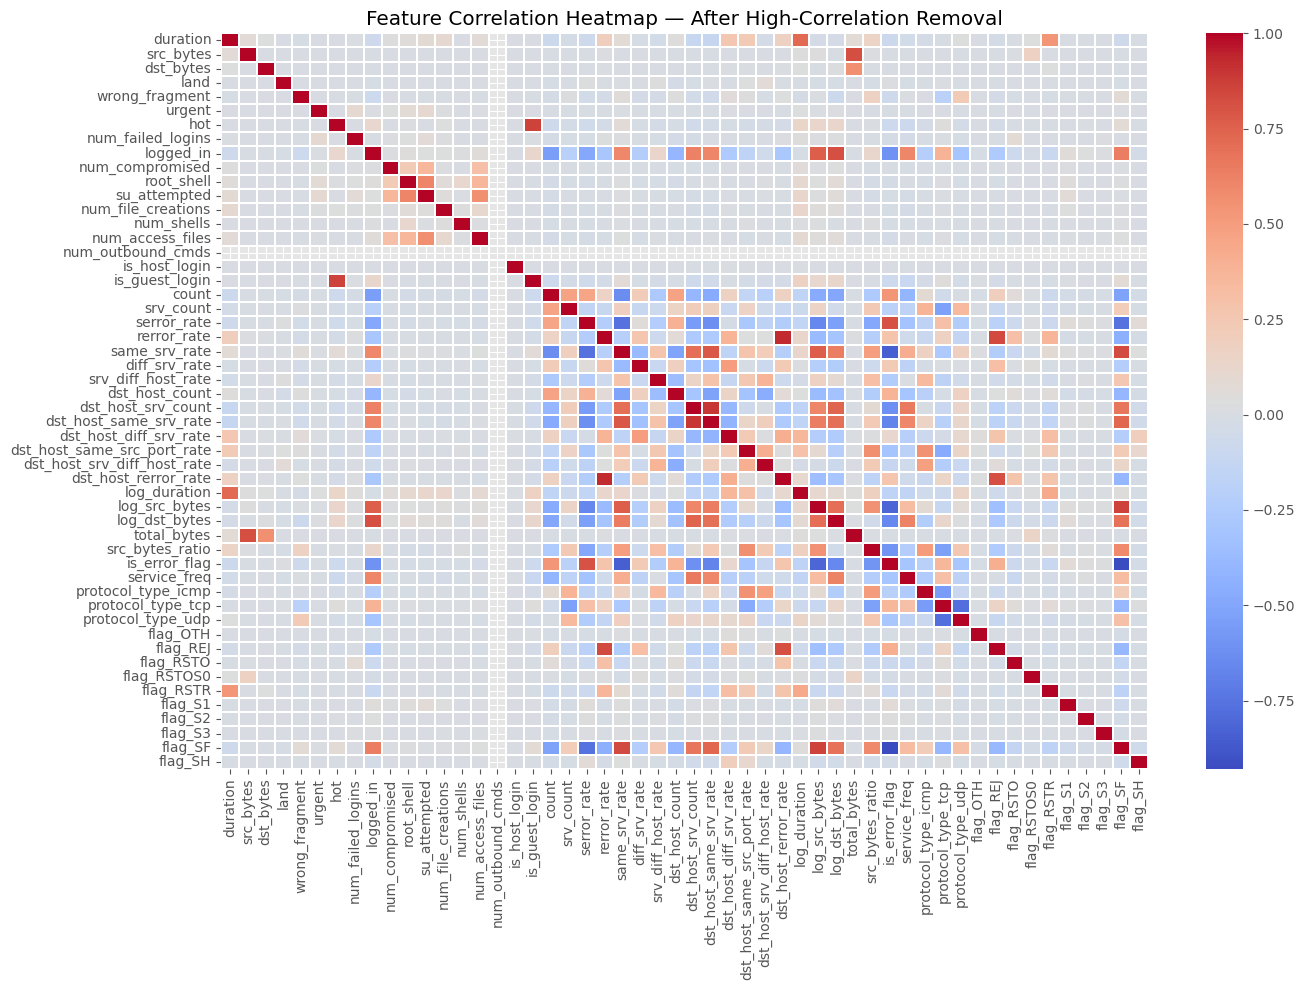

In [22]:
# Visualise the correlation heatmap after removal
plt.figure(figsize=(14, 10))
sns.heatmap(
    X_train_fs.corr(),
    cmap='coolwarm',
    linewidths=0.3,
    annot=False
)
plt.title('Feature Correlation Heatmap — After High-Correlation Removal')
plt.tight_layout()
plt.show()